In [1]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# Read the data
reports = pd.read_csv("scraped data for LDA/portnews1y.csv")
reports.head()
reports.info()

# Our spaCy model:
nlp = en_core_web_md.load()

# Tags we want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []

reports['Description'] = reports['Description'].astype(str)
for description in nlp.pipe(reports['Description']):
   proj_tok = [token.lemma_.lower() for token in description if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

# Add tokens to new column
reports['tokens'] = tokens
reports['tokens']

# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])
print(dictionary.token2id)

# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time         1033 non-null   object
 1   Title        1033 non-null   object
 2   Description  1013 non-null   object
 3   Link         1033 non-null   object
 4   Datetime     1033 non-null   object
dtypes: object(5)
memory usage: 84.2+ KB
{'aforementioned': 0, 'box': 1, 'carrier': 2, 'cgm': 3, 'charleston': 4, 'cma': 5, 'coast': 6, 'container': 7, 'decide': 8, 'destination': 9, 'dry': 10, 'east': 11, 'effective': 12, 'french': 13, 'india': 14, 'indian': 15, 'july': 16, 'lanka': 17, 'launch': 18, 'new': 19, 'norfolk': 20, 'ocean': 21, 'pakistan': 22, 'peak': 23, 'port': 24, 'pss': 25, 'revise': 26, 'savannah': 27, 'season': 28, 'sri': 29, 'subcontinent': 30, 'surcharge': 31, 'update': 32, 'york': 33, 'accept': 34, 'accord': 35, 'addition': 36, 'adopt': 37, 'advantage': 38, 'advocate': 39, 'agree

c:\Users\shea1\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


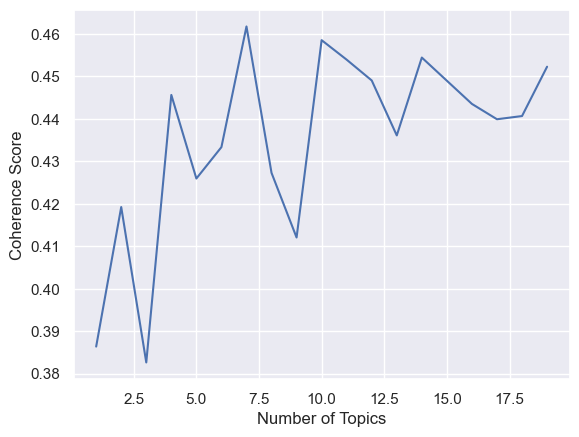

In [3]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [4]:
coherence_lda = cm.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.452302164119054


In [5]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=7, workers = 4, passes=100)

In [6]:
# Print topics
lda_model.print_topics(-1)

[(0,
  '0.032*"container" + 0.028*"port" + 0.027*"service" + 0.023*"terminal" + 0.014*"time" + 0.013*"customer" + 0.013*"rail" + 0.013*"system" + 0.012*"new" + 0.010*"transport"'),
 (1,
  '0.043*"port" + 0.020*"container" + 0.019*"say" + 0.013*"india" + 0.012*"cma" + 0.012*"vessel" + 0.011*"cgm" + 0.010*"accord" + 0.010*"company" + 0.010*"pay"'),
 (2,
  '0.038*"port" + 0.038*"ports" + 0.024*"terminal" + 0.019*"group" + 0.015*"new" + 0.015*"investment" + 0.013*"world" + 0.011*"logistic" + 0.010*"global" + 0.010*"dp"'),
 (3,
  '0.068*"port" + 0.014*"emission" + 0.013*"project" + 0.012*"energy" + 0.011*"hydrogen" + 0.010*"power" + 0.009*"green" + 0.009*"authority" + 0.009*"long" + 0.008*"supply"'),
 (4,
  '0.049*"terminal" + 0.036*"crane" + 0.026*"new" + 0.024*"container" + 0.020*"terminals" + 0.017*"equipment" + 0.016*"port" + 0.016*"apm" + 0.014*"operation" + 0.009*"order"'),
 (5,
  '0.057*"port" + 0.027*"terminal" + 0.022*"container" + 0.021*"project" + 0.021*"ship" + 0.017*"new" + 0.0

In [7]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [8]:
# Save the report
pyLDAvis.save_html(lda_display, 'saved html/portnews1y.html')

              x         y  topics  cluster       Freq
topic                                                
6     -0.231393  0.055753       1        1  20.024283
3      0.088942  0.118431       2        1  17.376121
5      0.033907  0.030335       3        1  15.892747
2      0.090726  0.089918       4        1  13.110956
4      0.110321 -0.070890       5        1  11.909982
0      0.041068 -0.165243       6        1  10.882342
1     -0.133572 -0.058305       7        1  10.803569


Text(0, 0.5, 'Y Coordinate')

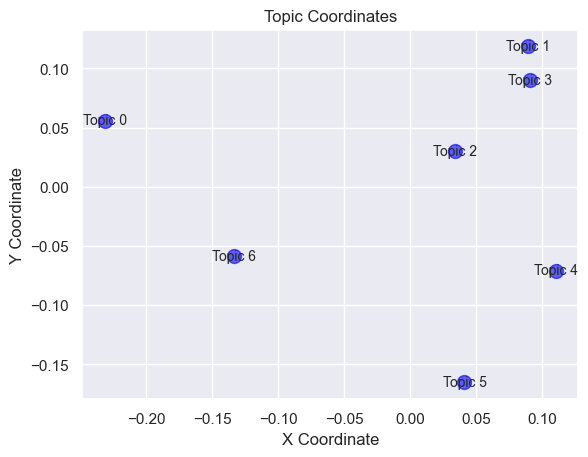

In [9]:
# Access the topic coordinates
topic_coordinates = lda_display.topic_coordinates

# Access the ordering of topics in the visualization
topic_order = lda_display.topic_order
print (topic_coordinates)

# Convert topic coordinates to NumPy array
topic_coordinates_array = topic_coordinates.values

# Create a scatter plot of the topic coordinates
plt.scatter(topic_coordinates_array[:, 0], topic_coordinates_array[:, 1], marker='o', c='blue', s=100, alpha=0.6)

# Add labels to the scatter plot
for topic, (x, y, *_) in enumerate(topic_coordinates_array):
    plt.text(x, y, f'Topic {topic}', fontsize=10, ha='center', va='center')

# Set plot title and axis labels
plt.title('Topic Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

In [10]:
reports['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(reports['Description']))]
reports.topic.value_counts()

topic
0    1530
2     178
1     157
3     132
6      73
4      64
5      18
Name: count, dtype: int64

In [11]:
# Associate topics with datetime
reports['topic'] = [sorted(lda_model[corpus[text]], key=lambda x: x[1], reverse=True)[0][0] for text in range(len(reports['Description']))]
reports['topic'] = reports['topic'].astype(int)

# Merge topics with corresponding datetime
topics = lda_model.print_topics(num_topics=7, num_words=5)
topics_dict = {topic[0]: topic[1] for topic in topics}
reports['topic_words'] = reports['topic'].map(topics_dict)

# Resulting DataFrame with topics associated with datetime
print(reports[['Datetime', 'topic', 'topic_words']])

       Datetime  topic                                        topic_words
0     30/6/2023      1  0.043*"port" + 0.020*"container" + 0.019*"say"...
1     30/6/2023      1  0.043*"port" + 0.020*"container" + 0.019*"say"...
2     30/6/2023      1  0.043*"port" + 0.020*"container" + 0.019*"say"...
3     29/6/2023      6  0.066*"port" + 0.058*"year" + 0.048*"teu" + 0....
4     29/6/2023      5  0.057*"port" + 0.027*"terminal" + 0.022*"conta...
...         ...    ...                                                ...
2147        NaN      0  0.032*"container" + 0.028*"port" + 0.027*"serv...
2148        NaN      0  0.032*"container" + 0.028*"port" + 0.027*"serv...
2149        NaN      0  0.032*"container" + 0.028*"port" + 0.027*"serv...
2150        NaN      0  0.032*"container" + 0.028*"port" + 0.027*"serv...
2151        NaN      0  0.032*"container" + 0.028*"port" + 0.027*"serv...

[2152 rows x 3 columns]


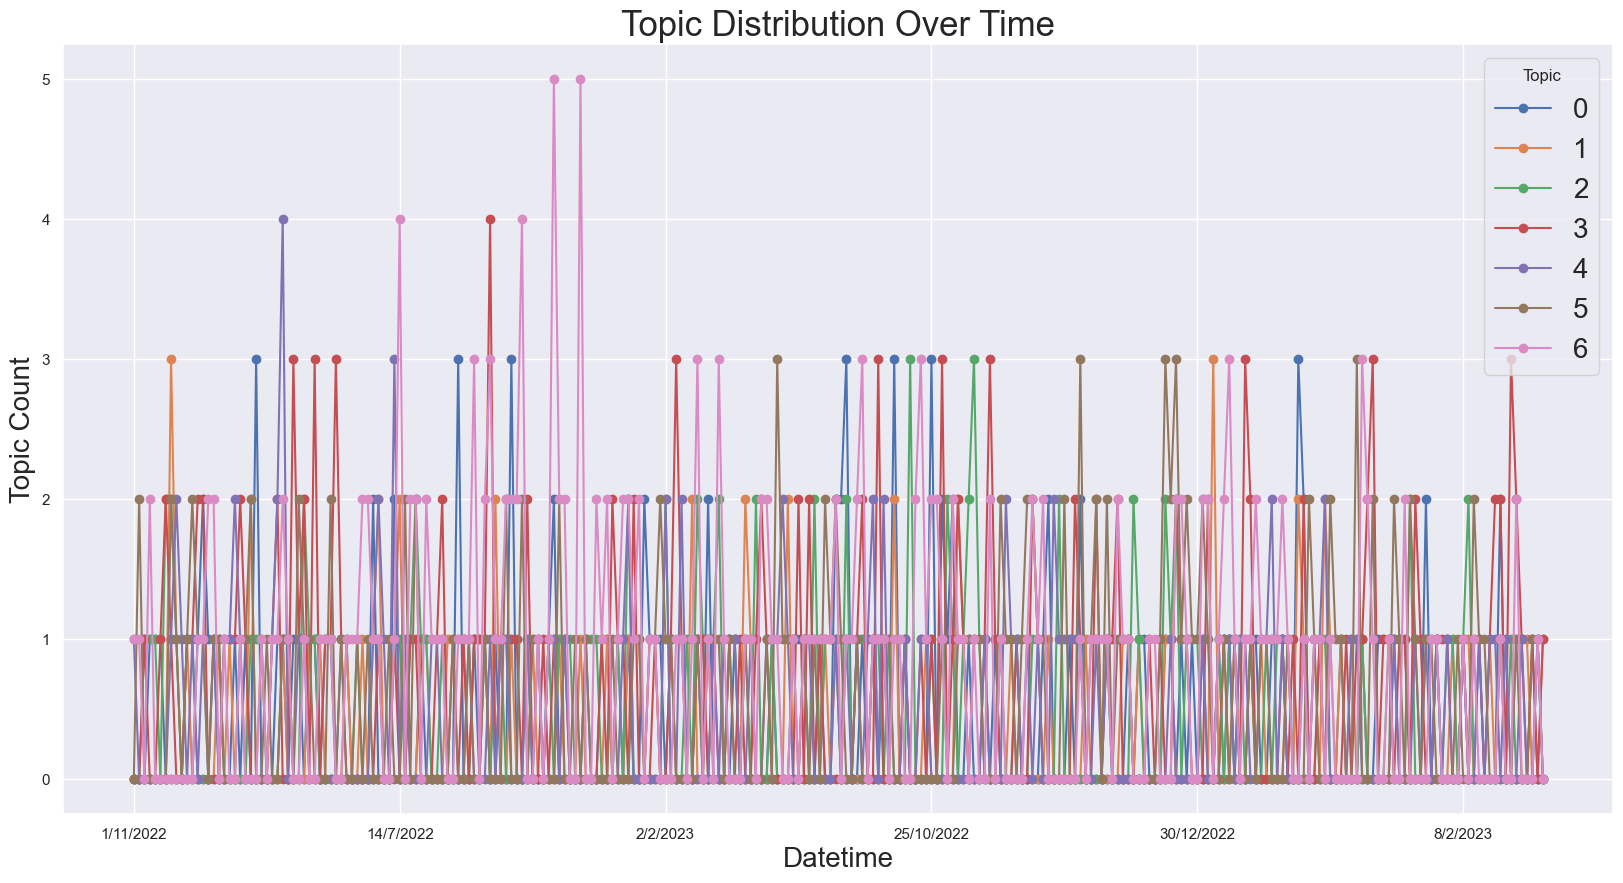

In [12]:
# Group the data by datetime and topic
grouped_data = reports.groupby(['Datetime', 'topic']).size().unstack().fillna(0)

# Plotting the distribution of topics over time
grouped_data.plot(kind='line', figsize=(20, 10), marker='o')

# Customize the plot
plt.title('Topic Distribution Over Time', fontsize=25)
plt.xlabel('Datetime', fontsize=20)
plt.ylabel('Topic Count', fontsize=20)
plt.legend(title='Topic', loc='upper right', fontsize=20)

# Show the plot
plt.show()